Average Area: 0.018906214900000017
比电容 Cp = 63.87234763513518 F/g


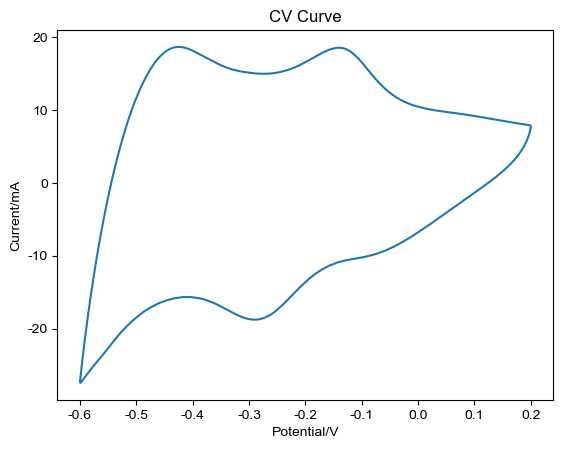

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 将画图部分的字体统一为Arial
from matplotlib import rcParams
config = {
    "font.family":'Arial',  # 设置字体类型
    "axes.unicode_minus": False  #解决负号无法显示的问题
}
rcParams.update(config)

# 假设每次循环的电压窗口为a ~ b，则要求电压扫描为b → a → b → a → ··· → b
# 第一个循环的数据不采用

# 每次运行前更改
# m为活性物质的质量，单位为mg
# k为CV扫描的速率，单位为mV/s

m = 1.85
k = 100

coordinates = []

# 读取文件内数据
with open('CV.txt', 'r') as file:
    for i in range(2):
        line = file.readline().strip()
        parts = line.split(',')
        
        # 确保每行有两个值
        if len(parts) == 2:
            try:
                V = float(parts[0])
                I = float(parts[1])
                
                # 如果是第一行
                if i == 0:
                    first_V = V
                    first_I = I
                # 如果是第二行
                elif i == 1:
                    second_V = V
                    second_I = I
            except ValueError:
                print(f"无法解析行：{line}")

    # 计算DST值
    if first_V is not None and second_V is not None:
        if first_V >= second_V:
            DST = 1
        else:
            DST = 0
    
    # 重置文件指针
    file.seek(0)
    
    # 重新读取文件并处理数据
    for line in file:
        # 移除行末的换行符并使用逗号分隔符分割行
        parts = line.strip().split(',')
        
        # 确保行包含两个值
        if len(parts) == 2:
            # 将两个值转换为浮点数，并创建坐标点
            try:
                V = float(parts[0])
                I = float(parts[1])
                if DST == 0:
                   V = -V
                   I = -I
                coordinate = (V, I)
                coordinates.append(coordinate)
            except ValueError:
                print(f"无法解析行：{line}")

# 定义函数，以计算多边形围成的面积
def calculate_polygon_area(coords):
    n = len(coords)
    area = 0

    j = n - 1
    for i in range(0, n):
        area += (coords[j][0] + coords[i][0]) * (coords[j][1] - coords[i][1])
        j = i

    return abs(area / 2)

# coordinates列表包含了每一个坐标(V,I)
# 获取V坐标的最大值
V_values = [coord[0] for coord in coordinates]  # 在使用前定义 V_values
max_first_coordinate = max(coordinates, key=lambda x: x[0])

max_first_coordinate = max(coordinates, key=lambda x: x[0])

# 获取所有最大值的索引
max_first_coordinate_indices = [i for i, coord in enumerate(coordinates) if coord[0] == max_first_coordinate[0]]
# 如果最大值只存在两个，而且索引列表长度为2
if len(max_first_coordinate_indices) == 2:
    # 复制 coordinates 的第一项并添加到末尾
    coordinates.append(coordinates[0][:])
    max_first_coordinate_indices = [i for i, coord in enumerate(coordinates) if coord[0] == max_first_coordinate[0]]


# 创建一个空列表来存储每个索引范围内的坐标
coordinate_ranges = []

# 使用循环获取每两个索引之间的坐标
for i in range(len(max_first_coordinate_indices) - 1):
    start_index = max_first_coordinate_indices[i]
    end_index = max_first_coordinate_indices[i + 1]

    
    # 使用切片提取坐标并存储在一个变量中
    selected_coordinates = coordinates[start_index:end_index]
    
    # 将坐标添加到列表中
    coordinate_ranges.append(selected_coordinates)

# 建立一个数组，储存每一个循环的面积
areas = []

# 计算每个循环的面积
for coordinates_range in coordinate_ranges:
    area = calculate_polygon_area(coordinates_range)
    areas.append(area)

# 计算循环面积的平均值
average_area = sum(areas[1:]) / (len(areas) - 1)  # 减去1是因为第一个循环通常是稳定的而不被计入

# 根据公式计算比电容值 Cp
delta_V = max(V_values) - min(V_values)
Cp = average_area * (10**6) / (2 * delta_V * m * k)  # 将面积单位转换为μF

print("Average Area:", average_area)
print("比电容 Cp =", Cp, "F/g")

# 将第二个循环的数据绘制成折线图
x_coordinates, y_coordinates = zip(*coordinate_ranges[1])

# 创建折线图
y_coordinates_milliamps = [i * 1000 for i in y_coordinates]  # 将电流单位转换为mA
plt.plot(x_coordinates, y_coordinates_milliamps)

# 添加标签和标题
plt.xlabel('Potential/V')
plt.ylabel('Current/mA')
plt.title('CV Curve')

# 不显示网格
plt.grid(False)

# 保存图形为矢量图
plt.savefig("CV_curve.eps", dpi=600, format="eps")

# 显示图形
plt.show()